## Linear Predictive Coding

In [ ]:
!python -m pip install sounddevice

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import lfilter, freqz
import sounddevice as sd
from librosa import lpc
import librosa
import math


In [11]:
# Prediction error
def perror(s, fStart, fAdv, a, pOrder):
    """
    Compute prediction error (Python version of MATLAB function)
    s: speech signal
    fStart: start index of current frame (0-based)
    fAdv: number of samples to compute
    a: LPC coefficients (without leading 1)
    pOrder: prediction order
    """
    perr = np.zeros(fAdv)
    for n in range(fAdv):
        temp = 0.0
        for k in range(pOrder):
            idx = n + fStart - k - 1
            if idx >= 0 and idx < len(s):
                temp += a[k] * s[idx]
        perr[n] = s[n + fStart] - temp
    return perr


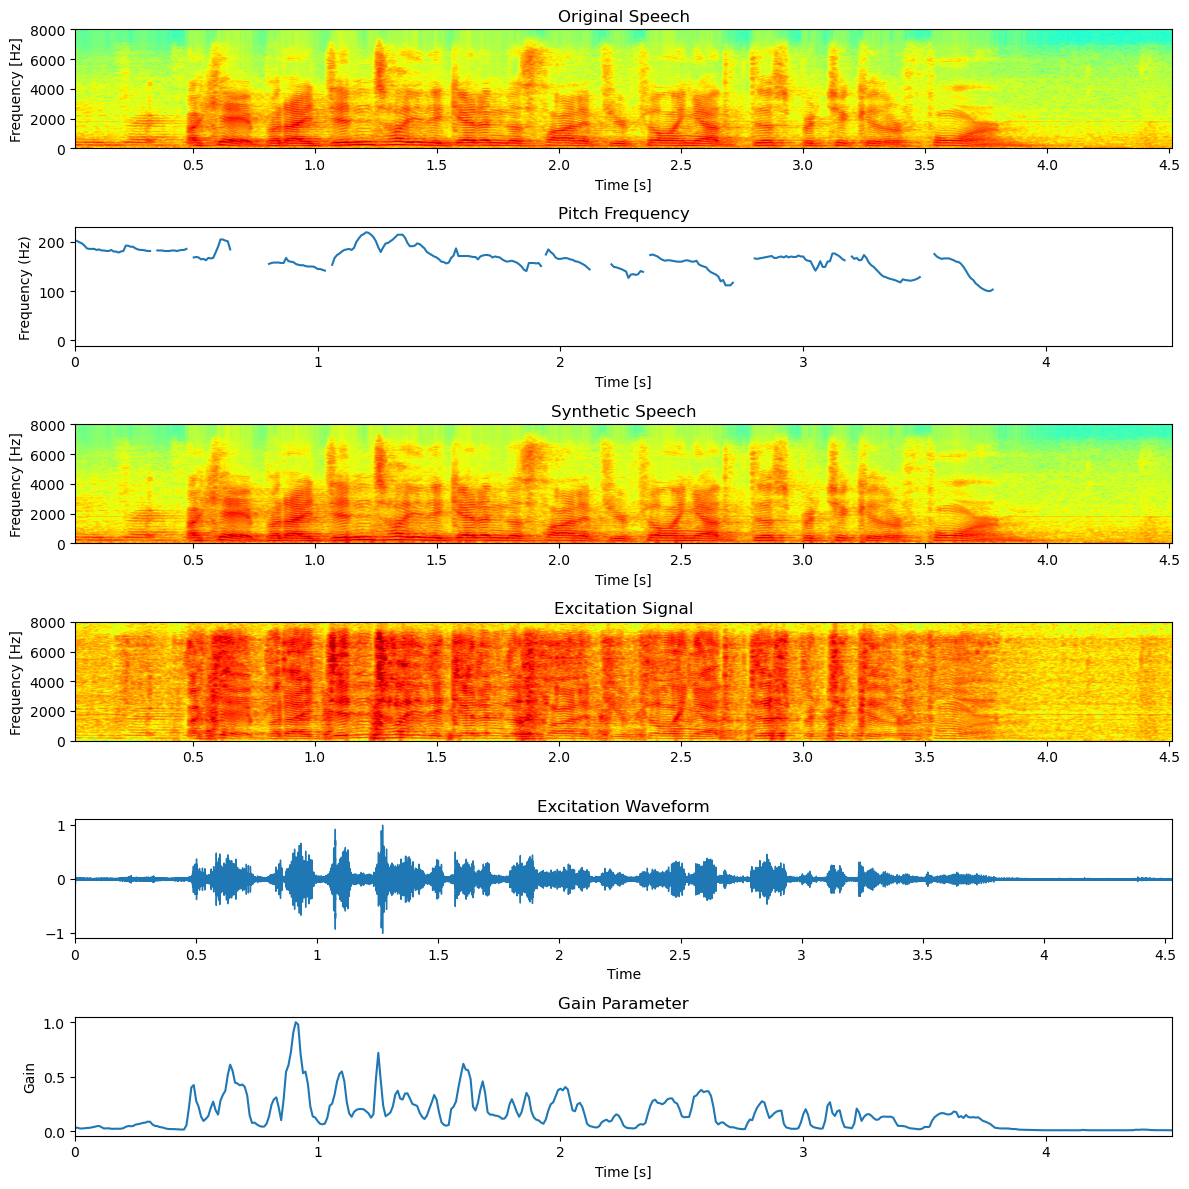

In [150]:
# Parameters
wavfile = './angry_speech.wav'
alpha = 0.94       # Pre-emphasis factor
jFactor = 0        # Pitch jitter factor
noiseFactor = 0.2  # Noise between pitch pulses
exmode = 'perror'  # Excitation mode: 'perror','noise', 'voice', or 'mix'
pOrder = 10        # LPC order
T = 60             # Pitch period in samples

# Read audio file
s, freq = librosa.load(wavfile, sr=librosa.get_samplerate(wavfile))
s = s.astype(np.float32) / np.max(np.abs(s))  # Normalize

# Frame parameters
frameSize = int(freq * 0.032)  # 32 ms per frame
frameAdv = int(freq * 0.01)    # 10ms frame shift <=> 100Hz frame rate
numSamples = len(s)
numFrames = int(np.ceil(numSamples / frameAdv)) - 1

# Estimate F0 (pitch frequency in Hz)
[f0, voice_flag, voice_prob] = librosa.pyin(s, fmin=100, fmax=600, sr=freq, 
                                            frame_length=frameSize, hop_length=frameAdv)

# Pre-emphasis
original_s = s.copy()
s = lfilter([1, -alpha], 1, s)

# Initialize variables
syn = np.array([])
e = np.array([])
G = np.array([])
filtmem = np.zeros(pOrder)  # Filter memory state

# Main processing loop
for frame in range(numFrames):
    frameStart = frame * frameAdv
    frameEnd = frameStart + frameSize
    
    if frameEnd >= numSamples:
        frameEnd = numSamples - 1
        numFrames = frame
        break
    
    # Extract and window frame
    x = s[frameStart:frameEnd]
    x = x * np.hamming(len(x))
    
    # Compute LPC coefficients
    a_coeffs = lpc(x, order=pOrder)       # a_coeffs[0]=1
    a = -a_coeffs[1:]  # Remove leading 1
    
    # Compute gain (RMS energy)
    gain = np.sqrt(np.sum(x**2) / len(x))
    G = np.append(G, gain)
    
    # Generate excitation based on mode
    if exmode == 'perror':
        exec_frame = perror(s, frameStart, frameAdv, a, pOrder)
    elif exmode == 'noise':
        exec_frame = gain * np.random.randn(frameAdv)
    elif exmode == 'voice':
        exec_frame = np.zeros(frameAdv)
        Tjitter = int(T + np.random.randn() * jFactor)
        pulse_indices = np.arange(0, frameAdv, Tjitter)
        exec_frame[pulse_indices] = gain
    elif exmode == 'mix':
        exec_frame = noiseFactor * np.random.randn(frameAdv) * gain
        Tjitter = int(T + np.random.randn() * jFactor)
        pulse_indices = np.arange(0, frameAdv, Tjitter)
        exec_frame[pulse_indices] = gain
    
    e = np.append(e, exec_frame)
    
    # Synthesize speech using excitation
    y, filtmem = lfilter([1], a_coeffs, exec_frame, zi=filtmem)
    syn = np.append(syn, y)

# Post-processing
syn = lfilter([1], [1, -alpha], syn)  # De-emphasis
s = original_s[:len(syn)]              # Trim original to match length

# Normalization
syn = syn / (1.2 * np.max(np.abs(syn)))
e = e / np.max(np.abs(e))
G = G / np.max(np.abs(G))

# Plotting
plt.figure(figsize=(12, 12))

# Spectrogram of original speech
plt.subplot(6, 1, 1)
plt.specgram(s, NFFT=512, Fs=freq, window=np.hamming(512), noverlap=511, cmap='jet', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Original Speech')

# Pitch frequency of original speech
plt.subplot(6, 1, 2)
f0 = f0[0:len(G)]
if math.isnan(f0[-1]):
    f0[-1] = 0
plt.plot(np.arange(len(G)) * frameAdv / freq, f0[0:len(G)])
plt.xlabel('Time [s]')
plt.ylabel('Frequency (Hz)')
plt.title('Pitch Frequency')
plt.tight_layout()
plt.margins(x=0)

# Spectrogram of synthetic speech
plt.subplot(6, 1, 3)
plt.specgram(syn, NFFT=512, Fs=freq, window=np.hamming(512), 
             noverlap=511, cmap='jet', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Synthetic Speech')

# Spectrogram of excitation
plt.subplot(6, 1, 4)
plt.specgram(e, NFFT=512, Fs=freq, window=np.hamming(512), 
             noverlap=511, cmap='jet', scale='dB')
plt.ylabel('Frequency [Hz]')
plt.title('Excitation Signal')

# Excitation waveform
plt.subplot(6, 1, 5)
librosa.display.waveshow(e, sr=freq, offset=0)
plt.title('Excitation Waveform')
plt.tight_layout()
plt.margins(x=0)

# Gain trajectory
plt.subplot(6, 1, 6)
plt.plot(np.arange(len(G)) * frameAdv / freq, G)
plt.xlabel('Time [s]')
plt.ylabel('Gain')
plt.title('Gain Parameter')
plt.tight_layout()
plt.margins(x=0)
plt.show()

# Play synthetic speech
sd.play(syn, samplerate=freq, blocking=True)

In [77]:
# Play original speech
sd.play(s, samplerate=freq, blocking=True)

In [85]:
# Play synthetic speech
sd.play(syn, samplerate=freq, blocking=True)